In [7]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.models import Sequential, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [8]:
#Le dataset choisi est un dataset préalablement séparé en données de test et d'entrainement du modèle. On a donc deux sous dossiers def_front pour les 
#les images avec défaut et ok_front pour les images de qualité ok. 
#Les images ont déjà été toutes définies en niveaux de grix ce qui nous épargne de cette étape 
#dans la mise en place de notre modèle.
train_directory='train/'
test_directory='test/'

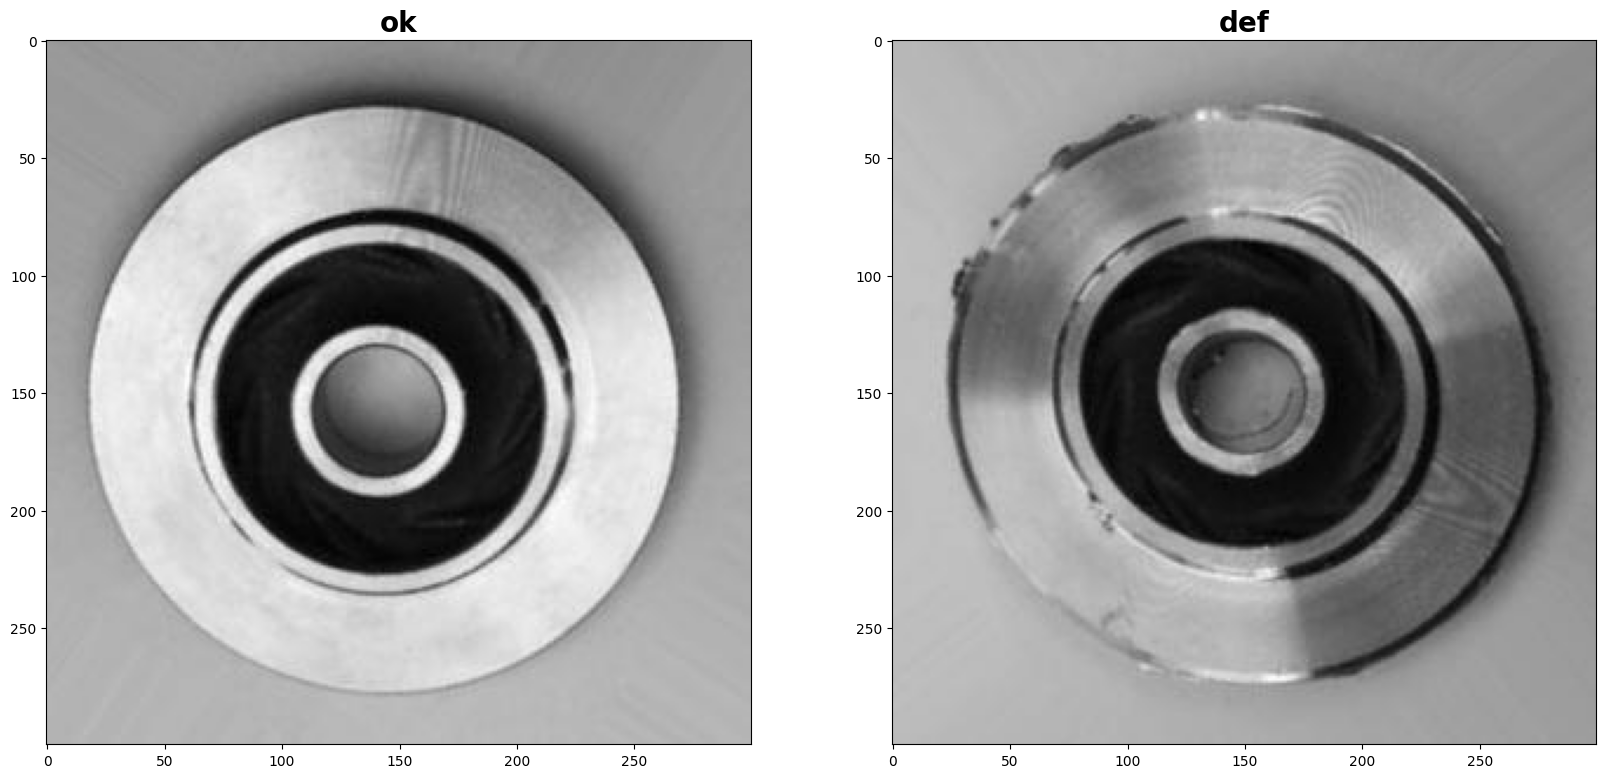

In [9]:
#essayons d'afficher une image ok puis une image avec défaut
import matplotlib.pyplot as plt
plt.figure(figsize=(20,16))

ok = plt.imread(train_directory + 'ok_front/cast_ok_0_1.jpeg')
plt.subplot(1, 2, 1)
plt.title("ok", weight='bold', size=20)
plt.imshow(ok,cmap='gray')
plt.grid(False)

not_ok = plt.imread(train_directory + 'def_front/cast_def_0_19.jpeg')
plt.subplot(1, 2, 2)
plt.title("def", weight='bold', size=20)
plt.imshow(not_ok,cmap='gray')
plt.grid(False)

plt.savefig('quality_detection', dpi=500, bbox_inches='tight')
plt.show()

#Opération de préprocessing
#1)Conversion en niveaux de gris
#2)Normalisation pour avoir des images binaires apès avoir convertit en niveau de gris
#3)Redimensionnement.Ici toutes les images seront mises au format 300*300 pixels

In [10]:


def preprocess_data(train_dir, test_dir, validation_split=0.2):
    # Define the ImageDataGenerator for training data with validation split
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=validation_split
    )

    # Load and preprocess the training data
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(300, 300),
        color_mode='grayscale',
        class_mode='binary',
        batch_size=64,
        subset='training'
    )

    # Load and preprocess the validation data
    validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(300, 300),
        color_mode='grayscale',
        class_mode='binary',
        batch_size=64,
        subset='validation'
    )

    # Define the ImageDataGenerator for test data
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Load and preprocess the test data
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(300, 300),
        color_mode='grayscale',
        class_mode='binary',
        batch_size=64
    )

    return train_generator, validation_generator, test_generator


In [11]:
train_data, validation_data, test_data=preprocess_data(train_directory, test_directory)

Found 5307 images belonging to 2 classes.
Found 1326 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [16]:
#Construire le modèle
def build_cnn_model(input_shape):
    cnn_model = Sequential()

    cnn_model.add(Conv2D(filters=32, kernel_size=3, strides=2, activation="relu", input_shape=input_shape))
    cnn_model.add(MaxPooling2D(pool_size=2, strides=2))

    cnn_model.add(Conv2D(filters=64, kernel_size=3, strides=2, activation="relu"))
    cnn_model.add(MaxPooling2D(pool_size=2, strides=2))

    cnn_model.add(Flatten())

    cnn_model.add(Dense(128, activation="relu"))
    cnn_model.add(Dropout(rate=0.2))

    cnn_model.add(Dense(64, activation="relu"))
    cnn_model.add(Dropout(rate=0.2))

    cnn_model.add(Dense(1, activation="sigmoid"))

    return cnn_model


# Get the input shape from the generator
input_shape = train_data.image_shape

# Build the CNN model
model = build_cnn_model(input_shape)
#compilation du modèle

model.compile(optimizer = "adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 149, 149, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 36, 36, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 20736)             0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [17]:
#Entrainement du modèle

def train_model(model, train_generator, validation_generator, epochs):
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs
    )
    return history
train_model(model,train_data,validation_data,100)

Epoch 1/100
83/83 [==============================] - 57s 671ms/step - loss: 0.6321 - accuracy: 0.6346 - val_loss: 0.4977 - val_accuracy: 0.7753
Epoch 2/100
83/83 [==============================] - 65s 784ms/step - loss: 0.4143 - accuracy: 0.8029 - val_loss: 0.3596 - val_accuracy: 0.8250
Epoch 3/100
83/83 [==============================] - 67s 810ms/step - loss: 0.2521 - accuracy: 0.8967 - val_loss: 0.1821 - val_accuracy: 0.9314
Epoch 4/100
83/83 [==============================] - 70s 845ms/step - loss: 0.1650 - accuracy: 0.9354 - val_loss: 0.1120 - val_accuracy: 0.9615
Epoch 5/100
83/83 [==============================] - 76s 912ms/step - loss: 0.1226 - accuracy: 0.9553 - val_loss: 0.1160 - val_accuracy: 0.9578
Epoch 6/100
83/83 [==============================] - 78s 932ms/step - loss: 0.0881 - accuracy: 0.9653 - val_loss: 0.0650 - val_accuracy: 0.9811
Epoch 7/100
83/83 [==============================] - 91s 1s/step - loss: 0.0598 - accuracy: 0.9802 - val_loss: 0.0473 - val_accuracy: 0.

In [20]:
history=train_model(model,train_data,validation_data,100)

Epoch 1/100
83/83 [==============================] - 54s 648ms/step - loss: 7.9036e-05 - accuracy: 1.0000 - val_loss: 0.0648 - val_accuracy: 0.9940
Epoch 2/100
83/83 [==============================] - 53s 638ms/step - loss: 1.6141e-04 - accuracy: 1.0000 - val_loss: 0.0670 - val_accuracy: 0.9932
Epoch 3/100
83/83 [==============================] - 53s 637ms/step - loss: 2.2299e-04 - accuracy: 0.9998 - val_loss: 0.0673 - val_accuracy: 0.9940
Epoch 4/100
83/83 [==============================] - 69s 829ms/step - loss: 2.5122e-04 - accuracy: 1.0000 - val_loss: 0.0526 - val_accuracy: 0.9940
Epoch 5/100
83/83 [==============================] - 67s 808ms/step - loss: 2.8424e-04 - accuracy: 0.9998 - val_loss: 0.0589 - val_accuracy: 0.9940
Epoch 6/100
83/83 [==============================] - 64s 769ms/step - loss: 6.5939e-04 - accuracy: 0.9996 - val_loss: 0.0803 - val_accuracy: 0.9925
Epoch 7/100
83/83 [==============================] - 62s 746ms/step - loss: 0.0040 - accuracy: 0.9985 - val_loss

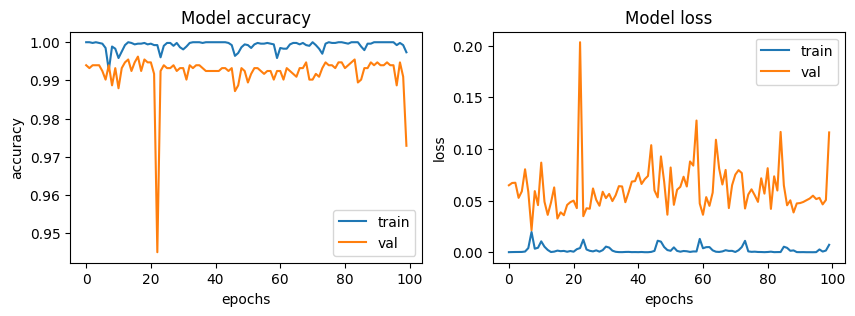

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.savefig('acc_curves.png', dpi=500, bbox_inches='tight')


In [19]:
model.save('quality_control.h5')